# Несбалансированные выборки. Практическая работа

## Цель практической работы

Научиться обрабатывать несбалансированные данные и обучать модели машинного обучения на таких данных.

## Что входит в работу


1. Загрузить данные и провести разведочный анализ.
2. Разделить данные на обучающую и тестовую выборки.
3. Подготовить данные для моделирования.
4. Сбалансировать данные методом SMOTE и обучить модель машинного обучения.
5. Обучить модель машинного обучения с использованием весов классов и кросс-валидации.
6. Сравнить метрики качества четырёх моделей.




## Что оценивается 

- Выполнены все этапы работы.
- Не допущена утечка данных при разделении выборок и подготовке данных.
- Данные корректным образом сбалансированы.
- Модели не переобучены.


## Как отправить работу на проверку

Скачайте файл с заданиями в материалах, откройте его через Jupyter Notebook и выполните задания. Сохраните изменения при помощи опции Save and Checkpoint из вкладки меню File или кнопки Save and Checkpoint на панели инструментов. Отправьте через форму ниже итоговый файл Jupyter Notebook (в формате .ipynb) или ссылку на него.


# Задача

Пусть у нас имеется некоторый набор данных `german_credit_data.csv` о заёмщиках банка:

* Age — возраст заёмщика.
* Sex — пол заёмщика.
* Job — тип работы заёмщика.
* Housing — тип жилья заёмщика.
* Saving accounts — объём средств на сберегательных счетах заёмщика.
* Checking account — объём средств на основном счёте заёмщика.
* Credit amount — размер кредита. 
* Duration — срок кредита (в месяцах).
* Purpose — цель кредита.
* Risk — таргет, допустил ли заёмщик просрочку платежей по кредиту.

Решите задачу классификации заёмщиков, чтобы банк умел заранее предсказывать просрочку платежей по кредиту. 



# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [135]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('german_credit_data.csv')
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [136]:
for i in df.columns:
    print(i, sum(df[i].isna()) / len(df))

Age 0.0
Sex 0.0
Job 0.0
Housing 0.0
Saving accounts 0.183
Checking account 0.394
Credit amount 0.0
Duration 0.0
Purpose 0.0
Risk 0.0


In [137]:
numerical_features = ['Age', 'Job', 'Credit amount']
categorical_features = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
target = 'Risk'

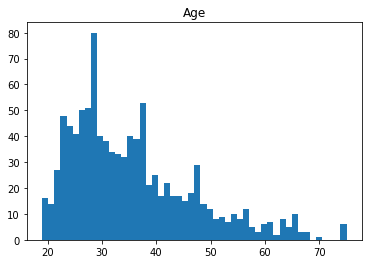

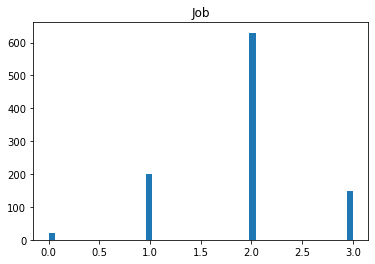

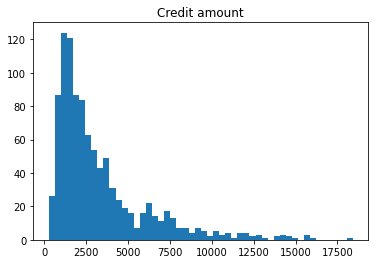

In [138]:
for i in numerical_features:
    plt.hist(df[i], bins=50)
    plt.title(i)
    plt.show()

In [139]:
for i in categorical_features:
    print(i)
    print(df[i].value_counts(dropna=False))
    print()

Sex
male      690
female    310
Name: Sex, dtype: int64

Housing
own     713
rent    179
free    108
Name: Housing, dtype: int64

Saving accounts
little        603
NaN           183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

Checking account
NaN         394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

Purpose
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64



In [140]:
df[target].value_counts(dropna=False)

good    700
bad     300
Name: Risk, dtype: int64

# Задание 2

Разделите датасет на обучающую и тестовую выборки в пропорции 80:20. Разделение должно быть стратифицированным по таргету Risk.

В этом и следующих заданиях используйте random_state = 1.

In [141]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 1

df_train, df_test = train_test_split(df, stratify=df[target], test_size=0.2, random_state=RANDOM_SEED)

# Задание 3

Проведите этап очистки и подготовки данных (data preparation) и подготовьте данные к моделированию.

In [142]:
for i in df_train.columns:
    print(i, sum(df_train[i].isna()) / len(df_train))

Age 0.0
Sex 0.0
Job 0.0
Housing 0.0
Saving accounts 0.17875
Checking account 0.38375
Credit amount 0.0
Duration 0.0
Purpose 0.0
Risk 0.0


In [143]:
df_train['Saving accounts'].value_counts()

little        485
moderate       90
quite rich     46
rich           36
Name: Saving accounts, dtype: int64

In [144]:
df_train['Checking account'].value_counts()

little      222
moderate    217
rich         54
Name: Checking account, dtype: int64

In [145]:
# заполним пропуски в Saving accounts и Checking account модой

df_train['Saving accounts'].fillna(df_train['Saving accounts'].mode()[0], inplace=True)
df_train['Checking account'].fillna(df_train['Checking account'].mode()[0], inplace=True)

df_test['Saving accounts'].fillna(df_test['Saving accounts'].mode()[0], inplace=True)
df_test['Checking account'].fillna(df_test['Checking account'].mode()[0], inplace=True)

In [147]:
# все категориальные переменные преобразуем с помощью ohe

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
encoded_data = ohe.fit_transform(df_train[categorical_features])
df_train_enc = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_features), index=df_train.index)
df_train = pd.concat([df_train, df_train_enc], axis=1)
df_train = df_train.drop(categorical_features, axis=1)

In [148]:
ohe = OneHotEncoder(sparse=False, drop='first')
encoded_data = ohe.fit_transform(df_test[categorical_features])
df_test_enc = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(categorical_features), index=df_test.index)
df_test = pd.concat([df_test, df_test_enc], axis=1)
df_test = df_test.drop(categorical_features, axis=1)

In [150]:
ohe = OneHotEncoder(sparse=False, drop='first')
ft = ohe.fit_transform(df_train[[target]])
df_train[target] = pd.DataFrame(ft, columns=[target], index=df_train.index)
df_train.head()

,Age,Job,Credit amount,Duration,Risk,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
561,24,1,1546,24,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
613,22,2,3632,24,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
352,38,3,3229,18,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
568,41,2,3979,48,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
295,26,2,9960,48,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [152]:
ohe = OneHotEncoder(sparse=False, drop='first')
ft = ohe.fit_transform(df_test[[target]])
df_test[target] = pd.DataFrame(ft, columns=[target], index=df_test.index)

# Задание 4

Сбалансируйте обучающую выборку методом SMOTE и обучите модель RandomForestClassifier. Подберите оптимальные гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.

In [61]:
!pip install imbalanced-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [153]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=RANDOM_SEED, k_neighbors=2)
X_train, y_train = os.fit_resample(df_train.drop(target, axis=1), df_train[target])

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

X_test, y_test = df_test.drop([target], axis=1), df_test[target]
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

0.650952380952381


# Задание 5

Обучите модель RandomForestClassifier с использованием весов классов. Подберите оптимальные веса и гиперпараметры с помощью GridSearch. Посчитайте метрику ROC-AUC на тестовой выборке.